# QRコード検出実験

このノートブックでは、QRコードの検出と処理の実験を行います。

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from pathlib import Path
import cv2
import math
from pyzbar.pyzbar import decode

# 警告を非表示にする
import warnings
warnings.filterwarnings('ignore')

## 画像の読み込みとテスト表示

## QRコード検出機能の実装

In [5]:
def detect_qr_code(image_path):
    """
    pyzbarを使用してQRコードを検出し、その四隅の座標と回転角度を返す関数
    
    Args:
        image_path (str or Path): QRコードを含む画像ファイルのパス、またはnumpy配列の画像
        
    Returns:
        tuple: (検出結果, 四隅の座標, 回転角度(度), デコードされたテキスト)
    """
    # 画像の読み込み
    if isinstance(image_path, str) or isinstance(image_path, Path):
        image = cv2.imread(str(image_path))
    else:
        # すでに画像データの場合
        image = image_path
        
    if image is None:
        return False, None, None, None
    
    # pyzbarはグレースケール画像でも動作するが、ここではRGBで処理
    # OpenCVはBGRなのでRGBに変換
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # QRコードのデコード
    decoded_objects = decode(rgb_image)
    
    if not decoded_objects:
        return False, None, None, None
    
    # 最初のQRコードを処理
    qr_code = decoded_objects[0]
    
    # 四隅の座標を取得
    polygon_points = qr_code.polygon
    corners = np.array([(p.x, p.y) for p in polygon_points], dtype=np.int32)
    
    # デコードされたテキスト
    decoded_text = qr_code.data.decode('utf-8')
    
    # 回転角度を計算（上辺を基準）
    # QRコードの向きを特定（ここでは簡易的に最初の2点を上辺とする）
    top_left = corners[0]
    top_right = corners[1]  # 実際には左から右への順序になっているとは限らない
    
    # 上辺と水平線のなす角度を計算
    dx = top_right[0] - top_left[0]
    dy = top_right[1] - top_left[1]
    angle_rad = math.atan2(dy, dx)
    angle_deg = math.degrees(angle_rad)
    
    return True, corners, angle_deg, decoded_text

In [6]:
def visualize_qr_detection(image_path):
    """
    QRコード検出結果を可視化する関数
    
    Args:
        image_path (str or Path): QRコードを含む画像ファイルのパス
    """
    # 画像の読み込み
    if isinstance(image_path, str) or isinstance(image_path, Path):
        image = cv2.imread(str(image_path))
        img_for_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCVはBGR、MatplotlibはRGB
    else:
        # すでに画像データの場合
        image = image_path
        img_for_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    # QRコード検出
    success, corners, angle, text = detect_qr_code(image)
    
    # 検出結果の表示
    plt.figure(figsize=(12, 10))
    
    if success:
        # QRコードの四隅に点を打つ
        result_image = img_for_display.copy()
        for i, point in enumerate(corners):
            cv2.circle(result_image, tuple(point), 10, (255, 0, 0), -1)
            # 点の番号を表示
            cv2.putText(result_image, str(i), (point[0]+15, point[1]), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2)
        
        # 四隅を線で結ぶ
        for i in range(4):
            cv2.line(result_image, tuple(corners[i]), tuple(corners[(i+1)%4]), (0, 255, 0), 3)
        
        plt.imshow(result_image)
        plt.title(f'QRコード検出結果 - 回転角度: {angle:.2f}度')
        
        # 検出結果を表示
        print(f"QRコードの四隅の座標:")
        for i, point in enumerate(corners):
            print(f"  点{i}: ({point[0]}, {point[1]})")
        print(f"回転角度: {angle:.2f}度")
        print(f"デコードされたテキスト: {text}")
    else:
        plt.imshow(img_for_display)
        plt.title('QRコードが検出できませんでした')
    
    plt.axis('off')
    plt.show()

## QRコードの生成と検出のテスト

In [12]:
# QRコードを生成するための関数
def generate_qr_code(data, filename="generated_qr.png", box_size=10, border=6):
    """
    QRコードを生成して保存する関数
    
    Args:
        data (str): QRコードに埋め込むデータ
        filename (str): 保存するファイル名
        size (int): QRコードのサイズ
    
    Returns:
        Path: 生成されたQRコードの画像パス
    """
    import qrcode
    
    # QRコードの生成
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=box_size,
        border=border,
    )
    qr.add_data(data)
    qr.make(fit=True)
    
    # 画像として出力
    img = qr.make_image(fill_color="black", back_color="white")
    
    # 画像を保存
    output_path = Path(filename)
    img.save(str(output_path))
    
    return output_path

QRコードを生成しました: test_qr.png
QRコードの四隅の座標:
  点0: (59, 59)
  点1: (59, 350)
  点2: (351, 351)
  点3: (350, 59)
回転角度: 90.00度
デコードされたテキスト: https://github.com/tokoroten/qrop_qr


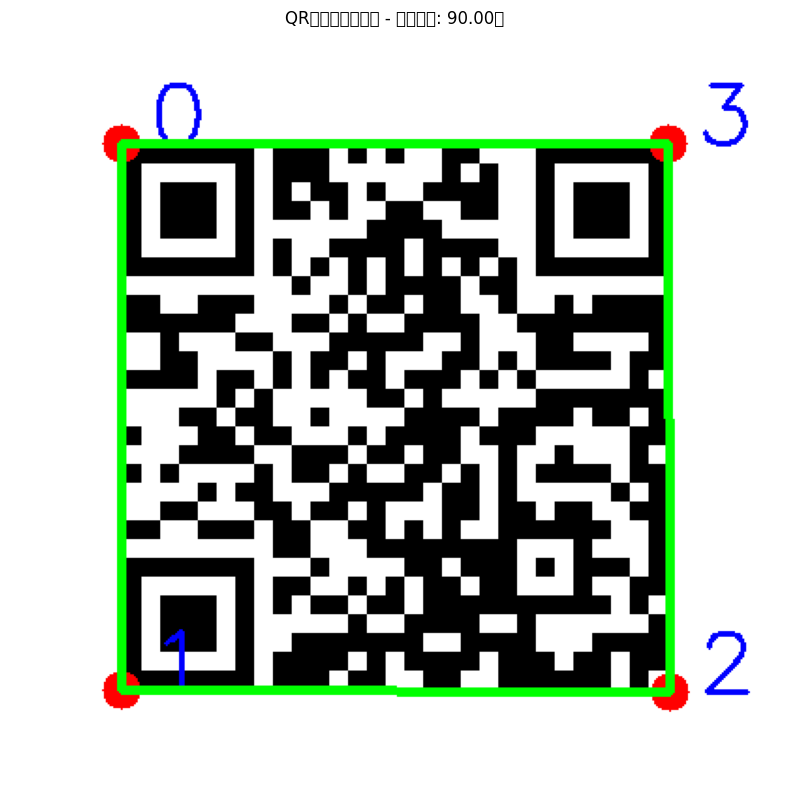

In [13]:
# QRコードを生成して検出をテスト
try:
    # QRコードの生成
    test_data = "https://github.com/tokoroten/qrop_qr"
    generated_qr_path = generate_qr_code(test_data, "test_qr.png",)
    
    print(f"QRコードを生成しました: {generated_qr_path}")
    
    # 生成したQRコードを検出
    visualize_qr_detection(generated_qr_path)
    
except Exception as e:
    print(f"エラーが発生しました: {e}")
    print("必要に応じて 'pip install qrcode[pil] pyzbar' または 'uv add qrcode[pil] pyzbar' を実行してください")

## QRコードを回転させた場合のテスト

In [14]:
def rotate_image(image, angle):
    """
    画像を指定された角度だけ回転させる関数
    
    Args:
        image: 回転させる画像
        angle (float): 回転角度（度）
        
    Returns:
        回転後の画像
    """
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    
    # 回転行列を取得
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # アフィン変換を適用
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), 
                                  flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, 
                                  borderValue=(255, 255, 255))
    
    return rotated_image

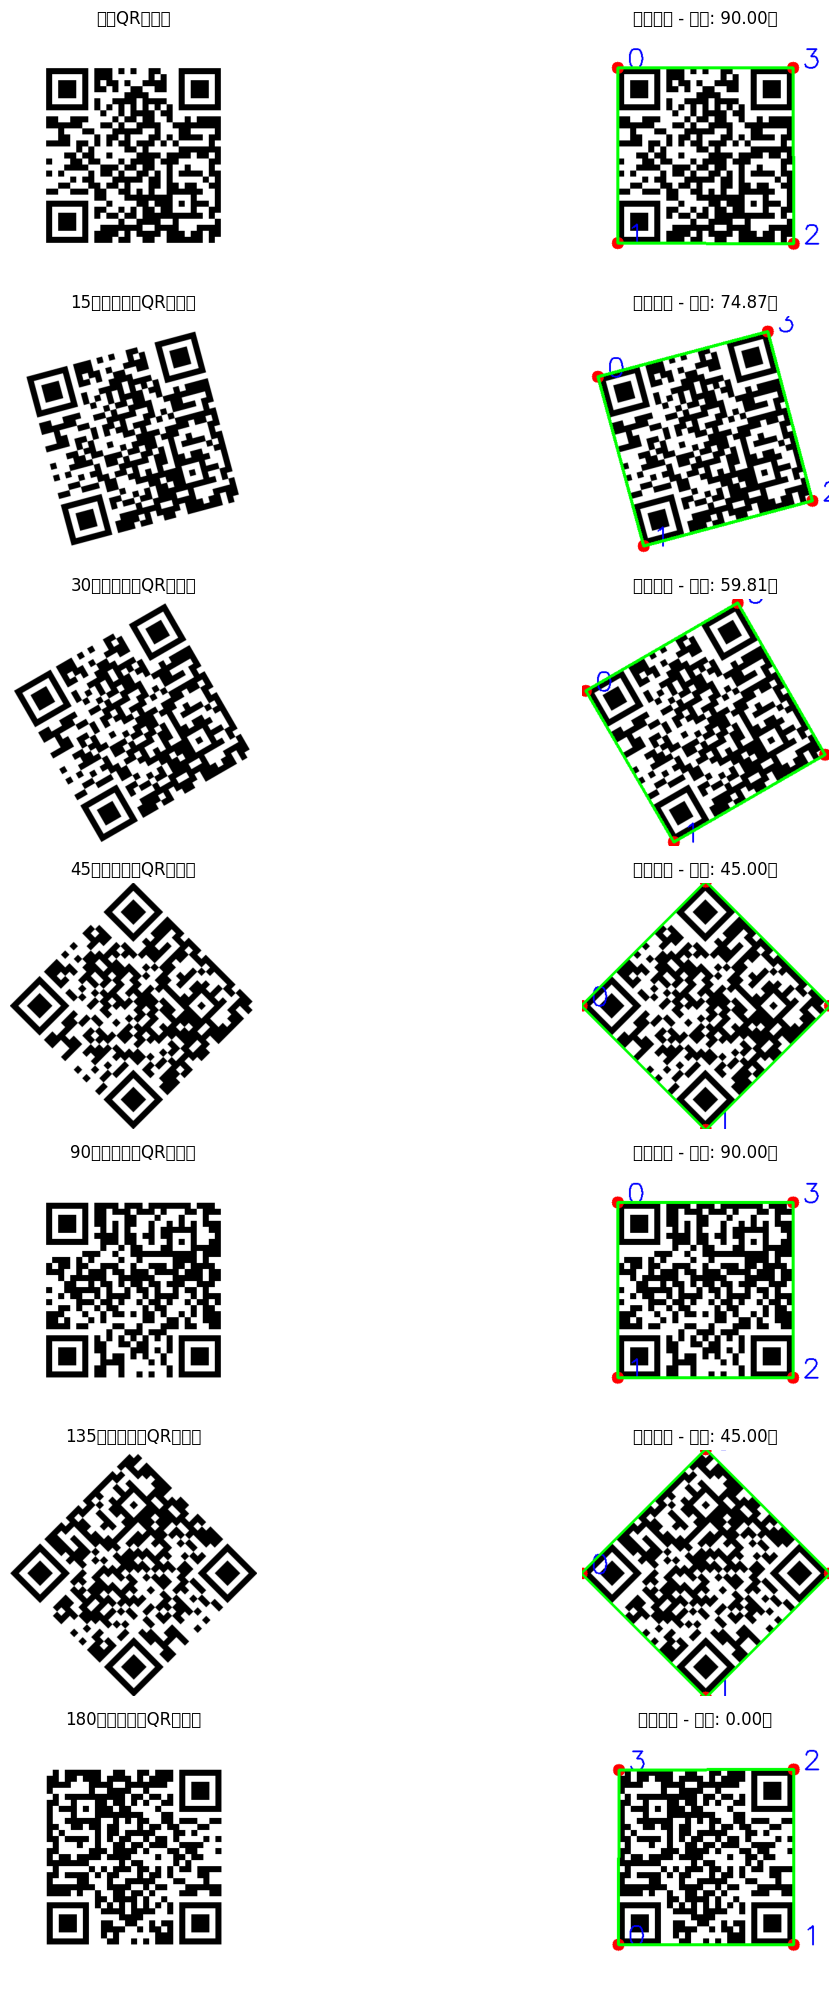

In [15]:
# 様々な角度に回転させたQRコードを検出するテスト
try:
    # QRコードを生成
    if not Path("test_qr.png").exists():
        test_data = "https://github.com/qrop_qr"
        generated_qr_path = generate_qr_code(test_data, "test_qr.png")
    else:
        generated_qr_path = Path("test_qr.png")
    
    # 画像の読み込み
    original_img = cv2.imread(str(generated_qr_path))
    
    # 異なる角度で回転
    angles = [15, 30, 45, 90, 135, 180]
    
    plt.figure(figsize=(15, 20))
    
    # 元の画像
    plt.subplot(len(angles) + 1, 2, 1)
    original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    plt.imshow(original_rgb)
    plt.title("元のQRコード")
    plt.axis('off')
    
    # 元の画像の検出結果
    success, corners, angle, text = detect_qr_code(original_img)
    plt.subplot(len(angles) + 1, 2, 2)
    if success:
        result_img = original_rgb.copy()
        for i, point in enumerate(corners):
            cv2.circle(result_img, tuple(point), 10, (255, 0, 0), -1)
            cv2.putText(result_img, str(i), (point[0]+15, point[1]), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2)
        for i in range(4):
            cv2.line(result_img, tuple(corners[i]), tuple(corners[(i+1)%4]), (0, 255, 0), 3)
        plt.imshow(result_img)
        plt.title(f"検出結果 - 角度: {angle:.2f}度")
    else:
        plt.imshow(original_rgb)
        plt.title("検出失敗")
    plt.axis('off')
    
    # 回転させたQRコードの検出テスト
    for i, rotation_angle in enumerate(angles):
        # 画像の回転
        rotated_img = rotate_image(original_img, rotation_angle)
        
        # 回転した画像の表示
        plt.subplot(len(angles) + 1, 2, 2*i + 3)
        rotated_rgb = cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB)
        plt.imshow(rotated_rgb)
        plt.title(f"{rotation_angle}度回転したQRコード")
        plt.axis('off')
        
        # QRコード検出
        success, corners, detected_angle, text = detect_qr_code(rotated_img)
        
        # 検出結果の表示
        plt.subplot(len(angles) + 1, 2, 2*i + 4)
        if success:
            result_img = rotated_rgb.copy()
            for j, point in enumerate(corners):
                cv2.circle(result_img, tuple(point), 10, (255, 0, 0), -1)
                cv2.putText(result_img, str(j), (point[0]+15, point[1]), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2)
            for j in range(4):
                cv2.line(result_img, tuple(corners[j]), tuple(corners[(j+1)%4]), (0, 255, 0), 3)
            plt.imshow(result_img)
            plt.title(f"検出結果 - 角度: {detected_angle:.2f}度")
        else:
            plt.imshow(rotated_rgb)
            plt.title("検出失敗")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"エラーが発生しました: {e}")

## READMEファイルのQRコードを検出するテスト

READMEの画像ファイルが見つかりました: ..\..\docs\image.png
QRコードの四隅の座標:
  点0: (326, 298)
  点1: (326, 403)
  点2: (432, 403)
  点3: (432, 298)
回転角度: 90.00度
デコードされたテキスト: {
'app':'CropQR',
'ver':'0.01',
'name': 'user_name',
'language': 'ja_jp',
'x': 1.1,
'y': 0,
'w': 10,
'h': 1.0,
}


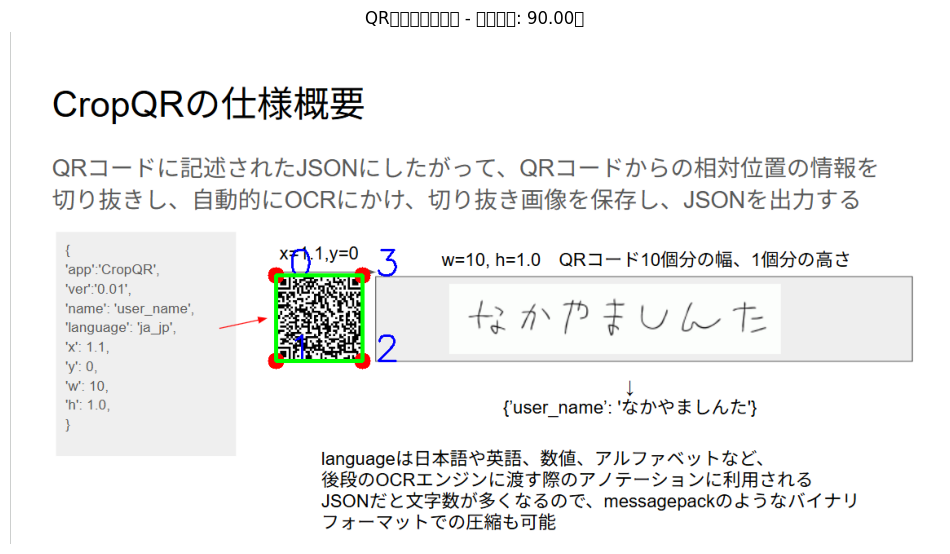

In [17]:
# READMEに使用されているQRコード画像のパス
readme_image_path = Path('../../docs/image.png')

# 画像が存在するか確認
if readme_image_path.exists():
    print(f"READMEの画像ファイルが見つかりました: {readme_image_path}")
    # QRコード検出の実行と可視化
    visualize_qr_detection(readme_image_path)
else:
    print(f"画像ファイルが見つかりません: {readme_image_path}")